
# Project Context:Brain Stroke Prediction
A stroke is a critical medical condition caused by interrupted blood flow to the brain, leading to cell death. It is primarily classified into two types: ischemic (due to blockage) and hemorrhagic (due to bleeding). Major risk factors include hypertension, heart disease, high glucose levels, and smoking. This analysis aims to leverage these clinical and demographic indicators to predict the likelihood of a patient suffering from a stroke, facilitating early detection and risk management.

### Dataset Overview:
This dataset contains medical and demographic records used to predict the likelihood of a patient suffering from a stroke. It combines physiological metrics (such as BMI and average glucose levels) with social factors (such as work type and residence) to serve as a binary classification problem. The goal is to train a model that can identify high-risk patients based on these input features.

### Attribute Information:
id: Unique identifier for each patient.

gender: The biological sex of the patient (Male, Female, Other).

age: The age of the patient.

hypertension: Indicates if the patient has high blood pressure (0 = No, 1 = Yes).

heart_disease: Indicates if the patient has a heart condition (0 = No, 1 = Yes).

ever_married: Marital status of the patient (Yes or No).

work_type: The nature of the patient's employment (e.g., Private, Self-employed, Govt_job, children).

Residence_type: The type of area where the patient resides (Urban or Rural).

avg_glucose_level: The average blood sugar level of the patient.

bmi: Body Mass Index (weight in kg / (height in m)^2).

smoking_status: The patient's smoking history (e.g., formerly smoked, never smoked, smokes, Unknown).

stroke: The target variable; returns 1 if the patient had a stroke and 0 if not.

#### Kaggle data source Link: https://www.kaggle.com/datasets/jillanisofttech/brain-stroke-dataset/data


## Project Workflow:
1) Data Loading & Initial Inspection
2) Exploratory Data Analysis (EDA)
3) Data Preprocessing
4) Model Building (Random Forest)
5) Hyperparameter Tuning
6) Model Evaluation & Interpretation
7) Model Comparison (Logistic Regression)

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import warnings

In [3]:
warnings.filterwarnings("ignore")

##  Data Loading & Initial Inspection

In [4]:
df = pd.read_csv('C:/Users/ramsa/ML/brain_stroke.csv')
df.head() 

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [5]:
df.count()

gender               4981
age                  4981
hypertension         4981
heart_disease        4981
ever_married         4981
work_type            4981
Residence_type       4981
avg_glucose_level    4981
bmi                  4981
smoking_status       4981
stroke               4981
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [7]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,43.419859,0.096165,0.055210,105.943562,28.498173,0.049789
std,22.662755,0.294848,0.228412,45.075373,6.790464,0.217531
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,25.000000,0.000000,0.000000,77.230000,23.700000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,113.860000,32.600000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000


## Exploratory Data Analysis (EDA)

In [8]:
df['work_type'].value_counts()

work_type
Private          2860
Self-employed     804
children          673
Govt_job          644
Name: count, dtype: int64

In [9]:
df['Residence_type'].value_counts()

Residence_type
Urban    2532
Rural    2449
Name: count, dtype: int64

In [10]:
df['smoking_status'].value_counts()

smoking_status
never smoked       1838
Unknown            1500
formerly smoked     867
smokes              776
Name: count, dtype: int64

In [11]:
X = df.drop(columns='stroke', axis=1)
y = df['stroke']

In [12]:
y.value_counts()

stroke
0    4733
1     248
Name: count, dtype: int64

## Data Preprocessing

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [14]:
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

In [15]:
# Scale the numeric features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode the categoricals 
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Model Building (Random Forest)

In [17]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced',random_state=42))
])

## Hyperparameter Tuning

In [18]:
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

In [19]:
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [20]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__max_depth': [None, 10, ...], 'classifier__min_samples_split': [2, 5], 'classifier__n_estimators': [50, 100]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [21]:
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters found:  {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best cross-validation score: 0.95


In [22]:
test_score = grid_search.score(X_test, y_test)  
print("Test set score: {:.2f}".format(test_score))

Test set score: 0.95


## Model Evaluation & Interpretation

In [23]:
y_pred = grid_search.predict(X_test)

In [24]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       947
           1       0.00      0.00      0.00        50

    accuracy                           0.95       997
   macro avg       0.47      0.50      0.49       997
weighted avg       0.90      0.95      0.92       997



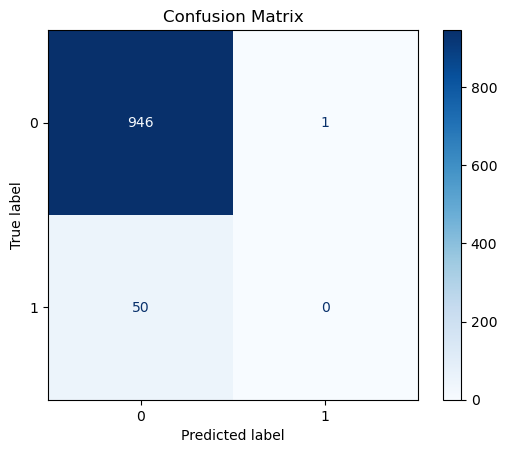

In [25]:
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [26]:
feature_importances=grid_search.best_estimator_['classifier'].feature_importances_

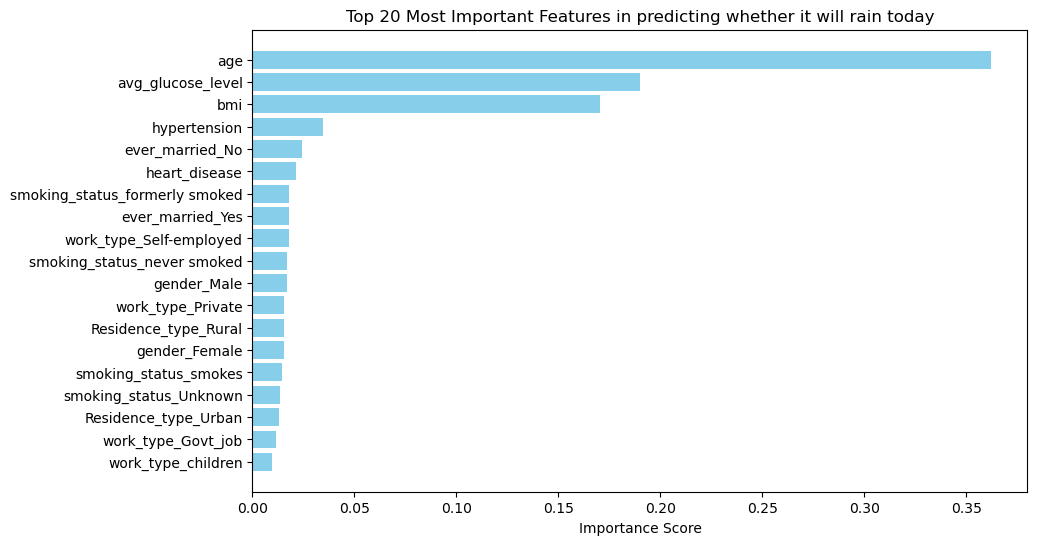

In [27]:
feature_names = numeric_features + list(grid_search.best_estimator_['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(categorical_features))

feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)

N = 20  # Change this number to display more or fewer features
top_features = importance_df.head(N)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title(f'Top {N} Most Important Features in predicting whether it will rain today')
plt.xlabel('Importance Score')
plt.show()

In [28]:
pipeline.set_params(classifier=LogisticRegression(random_state=42))


grid_search.estimator = pipeline


param_grid = {
    'classifier__solver' : ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight' : [None, 'balanced']
}

grid_search.param_grid = param_grid

# Fit the updated pipeline with Logistic Regression
grid_search.fit(X_train, y_train)

# Make predictions
y_pred = grid_search.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=No

## Model Comparison (Logistic Regression)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       947
           1       0.00      0.00      0.00        50

    accuracy                           0.95       997
   macro avg       0.47      0.50      0.49       997
weighted avg       0.90      0.95      0.93       997



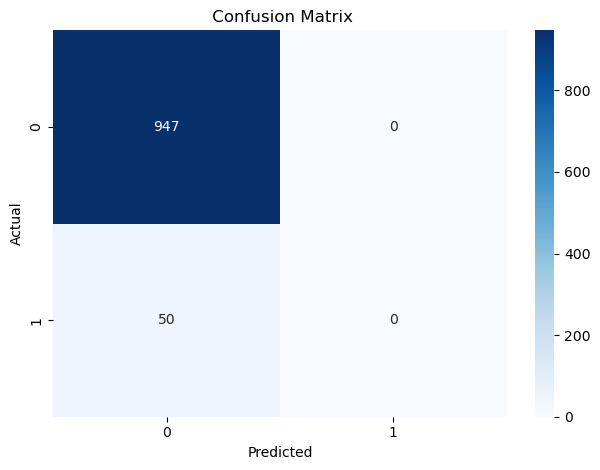

In [29]:
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

plt.title(' Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Conclusion

## 1. Performance Comparison

### Random Forest Classifier
- **Accuracy:** 95%  
- **True Positive Rate (Recall for Stroke = 1):** 0.00  

**Observation:**  
While the accuracy is high, the model failed to identify any actual stroke cases in the test set (0 True Positives). It is heavily biased toward the majority class (*No Stroke*).

---

### Logistic Regression
- **Accuracy:** 95%  
- **True Positive Rate (Recall for Stroke = 1):** 0.00  

**Observation:**  
Similar to Random Forest, this model achieved high accuracy by predicting *No Stroke* for almost every instance but failed to capture the minority class.

---

**Key Takeaway:**  
Both models suffer from the **Accuracy Paradox**. Due to the severe class imbalance (very few stroke cases compared to non-stroke), the models optimized for overall accuracy rather than detecting the rare positive cases.

---

## 2. Key Risk Factors (Feature Importance)

Based on the Random Forest analysis, the most significant predictors of stroke identified were:

- **Age:** The primary risk factor; risk increases significantly with age.  
- **Avg Glucose Level:** High blood sugar levels are a strong indicator.  
- **BMI:** Body Mass Index contributes to stroke risk, though often less than age.  

> *Note:* Refer to the **Feature Importance** plot generated in *Step 6* for the exact ranking.

---

## 3. Recommendations for Improvement

To improve the **True Positive Rate (Sensitivity)** and make the model clinically useful, the following algorithms and techniques should be explored:

### Handling Imbalance (Crucial Step)
- **SMOTE (Synthetic Minority Over-sampling Technique):**  
  Generate synthetic examples of stroke cases to balance the training data.
- **Undersampling:**  
  Reduce the number of *No Stroke* records to better match the minority class.

### Alternative Algorithms
- **XGBoost / LightGBM / CatBoost:**  
  Gradient boosting algorithms that often handle class imbalance and non-linear relationships better than standard Random Forest or Logistic Regression.
- **Support Vector Machines (SVM):**  
  Effective for high-dimensional spaces, especially when using class weighting.
- **Neural Networks:**  
  A Multi-Layer Perceptron (MLP) may capture complex patterns if trained on sufficiently balanced data.

